### Outlier Detection using autoencoders-First version
### Using  the whole data
#### Edgar Acuna
#### Abril 2021

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url= "https://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names)
yd=data['class']
Xd=data.iloc[:,0:8]

In [3]:
from sklearn.preprocessing import  StandardScaler
cols_to_norm = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
scaler = MinMaxScaler()
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
data.shape

(768, 9)

In [4]:
train_x = data.drop(['class'], axis=1) #drop the class column
train_x.info()
train_x = train_x.values #transform to ndarray
train_x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    float64
 1   plas    768 non-null    float64
 2   pres    768 non-null    float64
 3   skin    768 non-null    float64
 4   test    768 non-null    float64
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    float64
dtypes: float64(8)
memory usage: 48.1 KB


array([[0.35294118, 0.74371859, 0.59016393, ..., 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, ..., 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, ..., 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, ..., 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, ..., 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, ..., 0.45305514, 0.10119556,
        0.03333333]])

In [6]:
# No of Neurons in each Layer 
nb_epoch = 20
batch_size = 50
input_dim = train_x.shape[1] #num of columns, 8
encoding_dim = 4
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 24        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [7]:
import datetime
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(train_x, train_x,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - 
t_ini).total_seconds()))



df_history = pd.DataFrame(history.history) 

Time to run the model: 1.522534 Sec.


In [8]:
predictions = autoencoder.predict(train_x)
print(predictions)
train_x.shape

[[0.25501582 0.651968   0.5782056  ... 0.5279417  0.         0.23488817]
 [0.2166782  0.57269704 0.51094204 ... 0.45593998 0.         0.20507625]
 [0.2325382  0.605523   0.53874856 ... 0.4857327  0.         0.21738273]
 ...
 [0.2282392  0.59662837 0.5312094  ... 0.47765774 0.         0.21404439]
 [0.25286877 0.64753795 0.57443285 ... 0.5239111  0.         0.23321092]
 [0.20094028 0.5400995  0.48336446 ... 0.42637196 0.         0.19288439]]


(768, 8)

In [9]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': yd}, index=yd.index)
df_error.describe()

,reconstruction_error,Label
count,768.000000,768.000000
mean,0.026715,1.348958
std,0.021187,0.476951
min,0.002935,1.000000
25%,0.012670,1.000000
50%,0.020502,1.000000
75%,0.033902,2.000000
max,0.201309,2.000000


In [10]:
dfOutliers = df_error.index[df_error.reconstruction_error > .15].tolist()
len(dfOutliers)

2

In [11]:
print(dfOutliers)

[228, 445]


In [12]:
y=df_error['reconstruction_error'].tolist()
x = df_error.index.tolist()

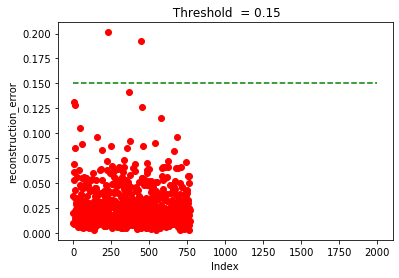

In [13]:
thresh=0.15
plt.plot(x, y, 'ro')
plt.ylabel('reconstruction_error')
plt.xlabel('Index')
plt.title(' Threshold  = ' +str(thresh))
plt.plot([0,2000],[thresh,thresh],"g--")

In [14]:
#cleaning the data from outliers
data3=data.drop(dfOutliers,axis=0)

### Outlier effect on the LDA Classifier

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
ldadis = LinearDiscriminantAnalysis().fit(Xd,yd)
scores = cross_val_score(ldadis, Xd, yd, cv=10)
print("Accuracy using LDA: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA: 0.77 (+/- 0.07)


In [16]:
y=data3['class']
X=data3.iloc[:,0:8]
#Haciendo el analisis discriminante y calculando el porcentaje de precision
ldadis = LinearDiscriminantAnalysis().fit(X,y)
scores = cross_val_score(ldadis, X, y, cv=10)
scores
print("Accuracy using LDA after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA after outlier removal: 0.77 (+/- 0.09)


#### Outlier effect on the KNN classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, Xd, yd, cv=10)
scores
print("Accuracy using k=5 neighbors: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors: 0.72 (+/- 0.09)


In [18]:
y=data3['class']
X=data3.iloc[:,0:8]
y1=y.to_numpy()
X1=X.to_numpy()
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, X1, y1, cv=10)
scores
print("Accuracy using k=5 neighbors after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors after outlier removal: 0.75 (+/- 0.09)
